In [75]:
import pandas as pd 
import numpy as np
import re
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# 1. Autocorrelation

'babies.zip` contains baby name frequencies per year (one file per year). You can treat each baby name as a time series.

1. Get the autocorrelation and partial autocorrelation for the names `Olivia`, `Newton` and `John`.

2. Which name do you expect to be the most popular in 2022? Use an ARIMA model and backtesting to pick 3 interesting candidates. Support your findings with a plot

In [6]:
#build a dataframe from the zip
#Takes 10 minutes because this isn;t a very efficient way to build a table.

archive = zipfile.ZipFile('data/babies.zip', 'r')

births = {}
idx = []
df = pd.DataFrame()

for i in range(1880, 2016):
    birth = archive.read('yob%s.txt'%i).decode('UTF-8')
    births['idx']= i
    for info in birth.split():
        infofo = info.split(',')
        name = infofo[0]
        num = int(infofo[2])
        births[name] = num
    df = df.append(births, ignore_index=True)
    df = df.fillna(0)


df.idx = pd.to_datetime(df.idx, format='%Y')
df = df.set_index('idx')

In [10]:
#1.
#I'm just going to do autocorrelations by hand since there isn't too many columns. I'm too lazy to do the same for pacf, so I will use statsmodels.

print('The autocorrelation for Olivia returns:', np.corrcoef(df.Olivia[1:], df.Olivia[:-1])[1][0])
print('The autocorrelation for Newton returns:', np.corrcoef(df.Newton[1:], df.Newton[:-1])[1][0])
print('The autocorrelation for John returns:', np.corrcoef(df.John[1:], df.John[:-1])[1][0])

print('The partial-autocorrelation (5 lags) for Olivia returns:', pacf(df.Olivia, nlags=5))
print('The partial-autocorrelation (5 lags) for Newton returns:', pacf(df.Newton, nlags=5))
print('The partial-autocorrelation (5 lags) for John returns:', pacf(df.John, nlags=5))

The autocorrelation for Olivia returns: 0.5465538472279289
The autocorrelation for Newton returns: 0.9618538338211877
The autocorrelation for John returns: 0.9926989495549
The partial-autocorrelation (5 lags) for Olivia returns: [ 1.          0.54812117  0.32203217  0.10912474 -0.03166025  0.02075753]
The partial-autocorrelation (5 lags) for Newton returns: [ 1.          0.96698106  0.17873831 -0.11281357 -0.22549949 -0.23509582]
The partial-autocorrelation (5 lags) for John returns: [ 1.          0.99139743 -0.35989958 -0.07417924 -0.19904572 -0.1133093 ]


In [4]:
#2.
#Alright, there are too many names here. Lets get the top 5 from the last 5 years.
names = df[-5:].sum().sort_values(ascending=False)[:5].index.to_list()

C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No f

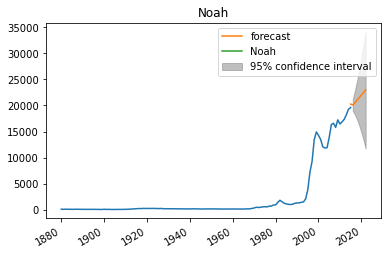

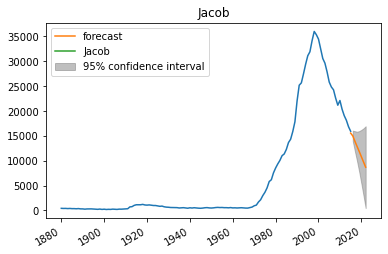

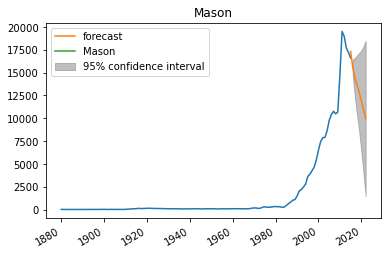

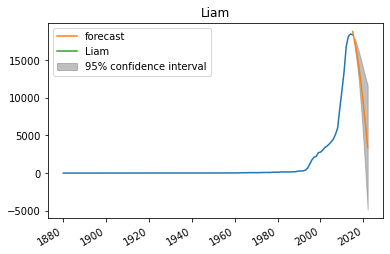

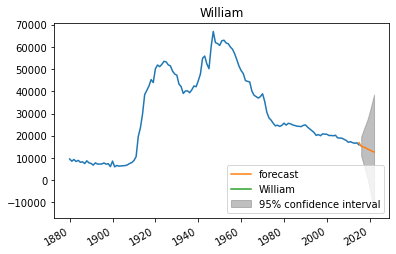

In [9]:
#I realize this isn't perfect. The assumpting here is that the value of the p and q values do not change across names. I believe this to be true, but it is an ssumption nonetheless.

for name in names:
    model = ARIMA(df[name], order=(3,2,0))
    res = model.fit(disp=-1)
    fig, ax = plt.subplots()
    plt.title(name)
    ax.plot(df[name])
    res.plot_predict('2015', '2022', ax=ax)

#Here, we see a clear trend that Noah will be the top name in 2022.

# 2. Counterfactual prediction testing

The [FRED](https://fred.stlouisfed.org) database has economic data useful for this question.

A common method to test the effect of a one-off event is to fit an ARIMA model up to the event, and compare the forecast to the actual data of what happened, then measure the gap between the forecast and the event data.

1. Use GDP and unemployment data with the Counterfactual prediction testing methodology to get an estimate of the magnitude of COVID (around March 2020 as a cutoff date) on these two statistics. Use an ARIMA model which fits best to the pre-COVID time series and compare the output of both. Provide a visualization.



In [112]:
GDP_df = pd.read_csv(r'C:\Users\David\Documents\code\Mod_5\5-5-time-series\data\GDP.csv')
precov_gdp = GDP_df[:292]
UN_df = pd.read_csv(r'C:\Users\David\Documents\code\Mod_5\5-5-time-series\data\UNRATE.csv')
precov_un = UN_df[:867]

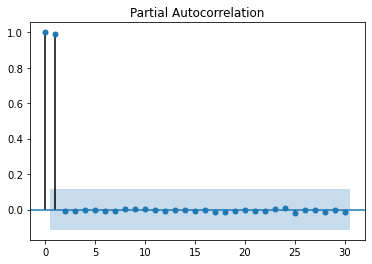

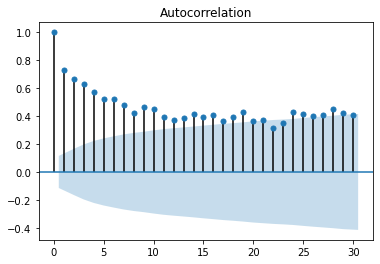

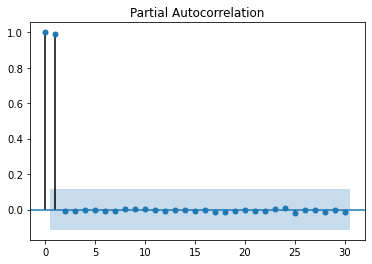

In [49]:
#Alright, this time because we only have two variables -I will use the visualizations to find the proper inputs for ARIMA.

plot_acf((precov_gdp['GDP'] - precov_gdp['GDP'].shift())[1:], lags=30)
plot_pacf(precov_gdp['GDP'], lags=30)

#Very strange looking which concerns me.

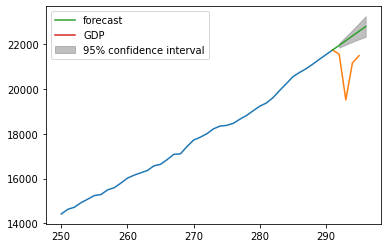

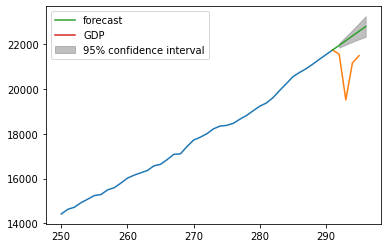

In [113]:
model = ARIMA(precov_gdp['GDP'], order=(4,2,0) )
res = model.fit()
fig, ax = plt.subplots()
ax.plot(precov_gdp['GDP'][250:])
ax.plot(GDP_df['GDP'][291:296])
res.plot_predict(291,296,ax=ax)

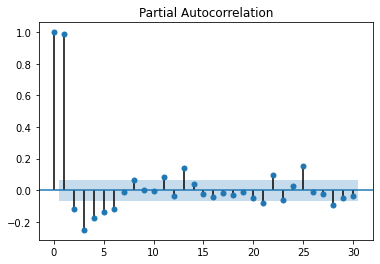

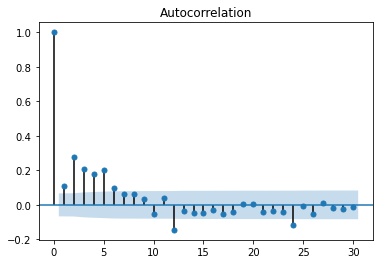

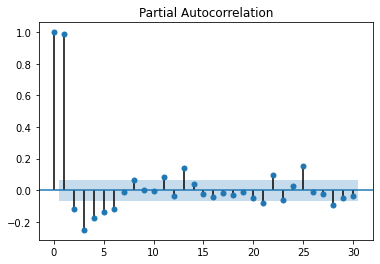

In [51]:
#Again.
plot_acf((precov_un['UNRATE'] - precov_un['UNRATE'].shift())[1:], lags=30)
plot_pacf(precov_un['UNRATE'], lags=30)

#Slightly more typical.

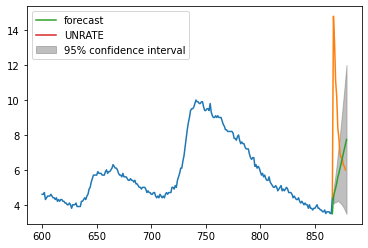

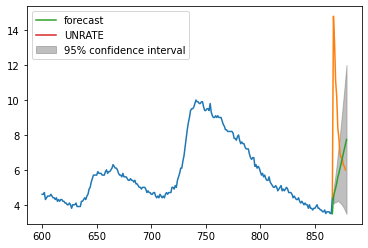

In [108]:
model = ARIMA(precov_un['UNRATE'], order=(4,2,0) )
res = model.fit(disp=-1)
fig, ax = plt.subplots()
ax.plot(precov_un['UNRATE'][600:])
ax.plot(UN_df['UNRATE'][866:879])
res.plot_predict(866,879,ax=ax)

2. Is GDP a unit root process or trend stationary? Use the 2008 and 2020 GDP shocks and statistical tests we've seen in class to provide an argument (it's possible event one says one thing and the other event says the opposite).

In [18]:
#2.
#This will be pretty simple, let's run a Dickey-Fuller test to determine stationarity.
X = GDP_df.GDP.values
print(adfuller(X))
print('With that p-value, clearly the original GDP is not stationy (duh).')


(3.570367154671125, 1.0, 3, 292, {'1%': -3.4529449243622383, '5%': -2.871489553425686, '10%': -2.572071437887033}, 3644.6243707804965)
With that p-value, clearly the original GDP is not stationy (duh).


In [131]:
#Putting some thought into this, I figured that we might get some interesting takeaway from market events by converting to a rolling window, then creating an RDD regression around the events.

df = GDP_df.copy()
df['rolmean'] = df.GDP.rolling(window=50).mean()
df.DATE = pd.to_datetime(df.DATE)

<ipython-input-134-0873a28d6555>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['day_count'] = range(1, (len(temp_df.index)+1))
<ipython-input-134-0873a28d6555>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['day_count'] = range(1, (len(temp_df.index)+1))
<ipython-input-134-0873a28d6555>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

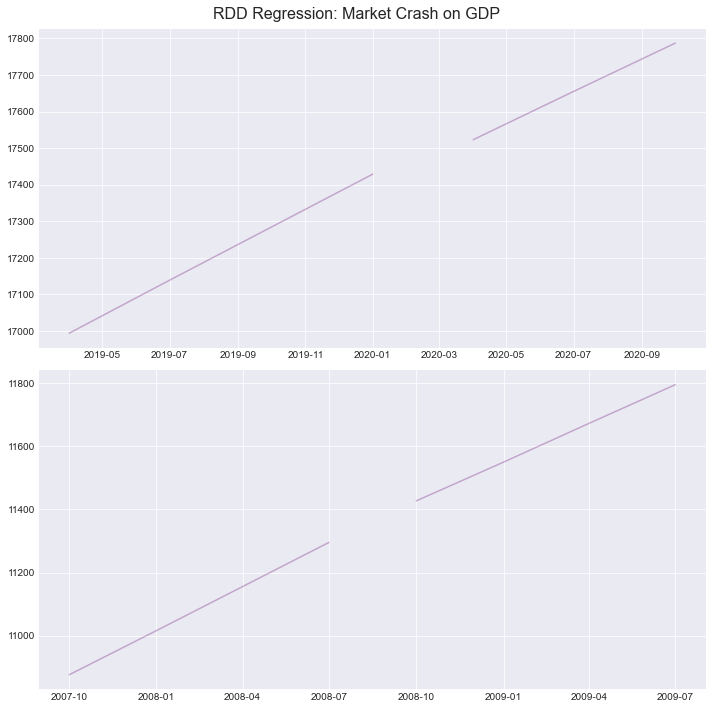

In [134]:
covid = pd.to_datetime("2020-03-20 00:00:00")
marketcrash = pd.to_datetime("2008-09-29 00:00:00")

def rdd_plot(df, time, ax, before):
    if before:
        temp_df = df.loc[( df.DATE > (time - pd.Timedelta(days=365) )) & ( df.DATE <= time )]
        colour = '#0008cf'
    else:
        temp_df = df.loc[( df.DATE < (time + pd.Timedelta(days=365) )) & ( df.DATE >= time )]
        colour = '#a3000c'

    temp_df['day_count'] = range(1, (len(temp_df.index)+1))
    y = temp_df.rolmean
    x = temp_df['day_count'] 
    X = sm.add_constant(x)

    model = sm.OLS(y, X).fit()
    yfit = model.predict(X)

    return ax.plot(temp_df.DATE, yfit, color='#680672', alpha=0.3), model

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10, 10))

covid_before, mod_cov1 = rdd_plot(df, covid, ax1, True)
covid_after, mod_cov2 = rdd_plot(df, covid, ax1, False)
market_before, mod_cra1 = rdd_plot(df, marketcrash, ax2, True)
market_after, mod_cra2 = rdd_plot(df, marketcrash, ax2, False)

fig.suptitle("RDD Regression: Market Crash on GDP", size=16)
plt.style.use(['seaborn-darkgrid'])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [130]:
print(mod_cov1.summary())
print(mod_cov2.summary())
print(mod_cra1.summary())
print(mod_cra2.summary())

                            OLS Regression Results                            
Dep. Variable:                rolmean   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.738e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           5.75e-05
Time:                        21:19:06   Log-Likelihood:                -7.8913
No. Observations:                   4   AIC:                             19.78
Df Residuals:                       2   BIC:                             18.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.685e+04      3.014   5590.517      0.0

Nothing too complicated here. First off -we need to disregard the R2 scores. It is too easy to fit a trend to a rolling mean, it just doesn't mean anything.

What is important is the coefficient which tells us the degree to which the GDP is growing. We can see that in the year following both events, we do not see a return to the previous trend.